# Titanic Data Processing with SparkXshards on Orca

Copyright 2016 The BigDL Authors.

SparkXshards in Orca allows users to process large-scale dataset using existing Python codes in a distributed and data-parallel fashion, as shown below. This notebook is an example of data exploration using SparkXshards on Orca. 

This notebook is adapted from [Titanic Data Processing with Python(0.813)](https://www.kaggle.com/code/chuanguy/titanic-data-processing-with-python-0-813/notebook).


In [ ]:
# Use seaborn for some plots
!pip install seaborn pandas numpy

In [ ]:
# import necessary libraries
from bigdl.orca import init_orca_context, stop_orca_context
import bigdl.orca.data.pandas
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Start an OrcaContext
sc = init_orca_context(memory="4g")

## Load data in parallel and get general information

Load data into data_shards, it is a SparkXshards that can be operated on in parallel, here each element of the data_shards is a panda dataframe read from a file on the cluster. Users can distribute local code of `pd.read_csv(dataFile)` using `bigdl.orca.data.pandas.read_csv(datapath)`.

In [ ]:
data_shards = bigdl.orca.data.pandas.read_csv('../titanic.csv')

In [6]:
# show the first couple of rows in the data_shards
data_shards.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [7]:
# count total number of rows in the data_shards
len(data_shards)

891

## Process data in parallel and visualize at local

`Xshards` provides a handy API of `transform_shard` to take and apply functions on each shard of the data in parallel. Users can define any function to transform a `Xshards` in a distributed fashion to process big dataset. 

Most of the times, the data is too big to be be brought to a single node for visualization, `SparkXshards` provides `SparkXshards.sample_to_pdf(frac)` to to sample a portion of the data_shards and bring back to a single panda dataframe at local, then users can use traditional tools on the papandas dataframe for visualization at local. 

Only three sets of plots from the original notebook is shown here since the logic is the same.

### Analyze 'Fare', 'Cabin' and  'Survived'

Process 'passengerIds' and 'Cabin' in parallel.

In [8]:
# drop passengerIds  since it is not needed
def drop_passenger(df):
    df = df.drop(['PassengerId'], axis=1)
    return df
data_shards = data_shards.transform_shard(drop_passenger)

In [9]:
# fillna, apply, replace, map
def process_cabin(df):
    df['Cabin'] = df['Cabin'].fillna('X')
    df['Cabin'] = df['Cabin'].apply(lambda x: str(x)[0])
    df['Cabin'] = df['Cabin'].replace(['A', 'D', 'E', 'T'], 'M')
    df['Cabin'] = df['Cabin'].replace(['B', 'C'], 'H')
    df['Cabin'] = df['Cabin'].replace(['F', 'G'], 'L')
    df['Cabin'] = df['Cabin'].map({'X': 0, 'L': 1, 'M': 2, 'H': 3})
    df['Cabin'] = df['Cabin'].astype(int)
    return df
data_shards = data_shards.transform_shard(process_cabin)
data_shards.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,3,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,3,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S


Plot relationship between 'Cabin', 'Fare' and 'Survived' at local.

,Fare
Cabin,
0,19.157325
1,17.493135
2,49.281278
3,106.072642


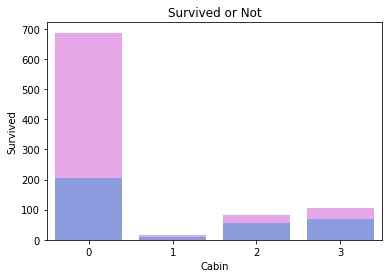

In [10]:
pdf = data_shards.select(['Cabin', 'Survived', 'Fare']).sample_to_pdf(frac=1.0)
ax = plt.axes()
data = pdf.groupby(['Cabin'])[['Survived']].count()
sns.barplot(x=data.index, y=data['Survived'], alpha=0.8, color='violet', ax=ax)
data = pdf.groupby(['Cabin'])[['Survived']].sum()
sns.barplot(x=data.index, y=data['Survived'], alpha=0.8, color='cornflowerblue', ax=ax)
ax.set_title('Survived or Not')
pdf.groupby(['Cabin'])[['Fare']].mean() 

### Analyze 'Sex' and  'Survived'

Encode 'Sex', 'Pclass' in parallel

In [11]:
def encode(data):
    data['Sex'] = data['Sex'].map({'female': 1, 'male': 0})
    data['Pclass'] = data['Pclass'].map({1: 3, 2: 2, 3: 1}).astype(int)
    data.loc[data['Sex'] == 0, 'SexByPclass'] = data.loc[data['Sex'] == 0, 'Pclass']
    data.loc[data['Sex'] == 1, 'SexByPclass'] = data.loc[data['Sex'] == 1, 'Pclass'] + 3
    return data
data_shards = data_shards.transform_shard(encode)
data_shards.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexByPclass
0,0,1,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0,S,1.0
1,1,3,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,3,C,6.0
2,1,1,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0,S,4.0
3,1,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,3,S,6.0
4,0,1,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0,S,1.0


Plot relationship between 'Survived' and 'SexByPclass' at local

<AxesSubplot:xlabel='SexByPclass'>

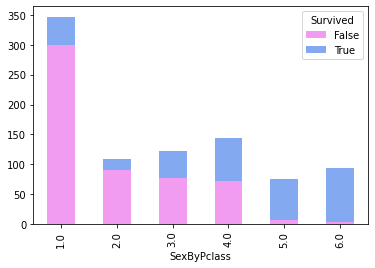

In [12]:
pdf = data_shards.select(['Survived', 'SexByPclass']).sample_to_pdf(frac=1.0)
temp = pd.crosstab([pdf.SexByPclass,], pdf.Survived.astype(bool))
temp.plot(kind='bar', stacked=True, color=['violet','cornflowerblue'], alpha=0.8, grid=False)

Process 'Sex', 'Pclass' in parallel

In [13]:
def fill_missing_embarked(data):
    freq_port = data['Embarked'].mode()[0]
    data['Embarked'] = data['Embarked'].fillna(freq_port)
    data['Embarked'] = data['Embarked'].map({'S': 0, 'Q': 1, 'C': 2}).astype(int)
    return data

data_shards = data_shards.transform_shard(fill_missing_embarked)
data_shards.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexByPclass
0,0,1,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0,0,1.0
1,1,3,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,3,2,6.0
2,1,1,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0,0,4.0
3,1,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,3,0,6.0
4,0,1,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0,0,1.0


Plot relationship between 'Sex' and 'Pclass' at local

<AxesSubplot:ylabel='Embarked'>

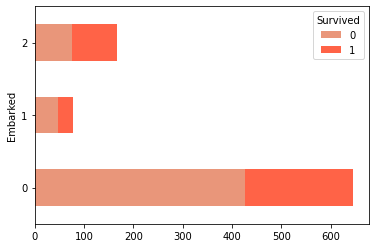

In [14]:
pdf = data_shards.select(['Survived', 'Embarked']).sample_to_pdf(frac=1.0)
temp = pd.crosstab(pdf.Embarked, pdf.Survived)
temp.plot(kind='barh', stacked=True, color=['darksalmon','tomato'], grid=False)

### Analyze 'Fare' and  'Survived'

Process 'Fare' in parallel

In [15]:
def fare_info(data):
    data.loc[data.Fare.isnull(), 'Fare'] = data['Fare'].mean()
    data['Fare'] = data['Fare'].astype(int)
    return data

data_shards = data_shards.transform_shard(fare_info)
data_shards.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexByPclass
0,0,1,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7,0,0,1.0
1,1,3,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71,3,2,6.0
2,1,1,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7,0,0,4.0
3,1,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53,3,0,6.0
4,0,1,"Allen, Mr. William Henry",0,35.0,0,0,373450,8,0,0,1.0


Plot relationship between 'Survived' and 'Fare' at local

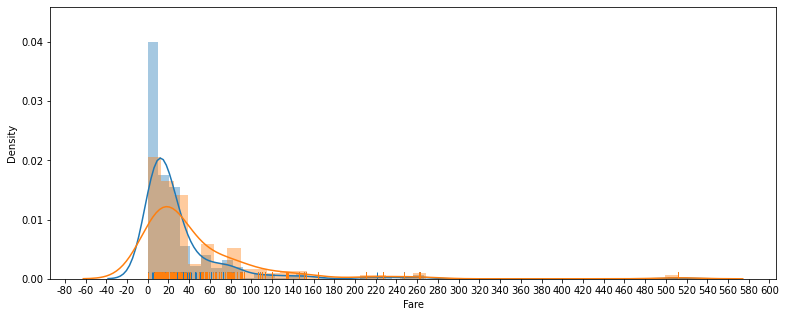

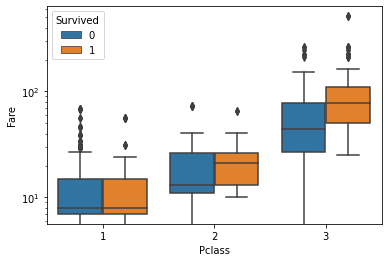

In [16]:
pdf = data_shards.select(['Pclass', 'Fare', 'Survived']).sample_to_pdf(frac=1.0)
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
xmajorLocator   = MultipleLocator(20)  # set the major locator to multiples of 5
xmajorFormatter = FormatStrFormatter('%1.0f')

fig, ax = plt.subplots(figsize=(13, 5))
sns.distplot(pdf['Fare'], kde = True, rug = True)
sns.distplot(pdf.loc[pdf['Survived']==1, 'Fare'], kde = True, rug = True)
ax.xaxis.set_major_locator(xmajorLocator)  
ax.xaxis.set_major_formatter(xmajorFormatter) 
plt.show()

ax = sns.boxplot(x="Pclass", y="Fare", hue="Survived", data=pdf);
ax.set_yscale('log')